In [41]:
import graphviz as gv
import copy
def make_cfg(fname,printIns=False):    
    cfg={}
    #load all instructions
    with open(fname, 'r') as f:
        operations = f.readlines()
        instructions = [o.split(' ') for o in operations]
    
    gen_ins=('Plus','Minus','Times','Greater','And','Or','GreaterEq','Equal','Not','Move')
    
    #helper functions
    op=lambda i: i[0]
    i0=lambda i: i[1]
    i1=lambda i: i[2]
    output=lambda i: i[3]
    block=lambda i: i[4].strip('\n')
    block_of_label=lambda lab: [block(i) for i in instructions if (op(i)=='Label' and i0(i)==lab)][0]
    instruction=lambda i: (op(i),i0(i),i1(i),output(i),block(i))
    jumpto_uncond=lambda i: block_of_label(i0(i))
    jumpto_cond=lambda i: block_of_label(i1(i))
    moves = lambda ins: [instruction(i) for i in ins if op(i)=='Move'] ##extract moves from list of instructions
    instructions_in_block = lambda b: [instruction(i) for i in instructions if block(i)==b] #extract all instructions from block b
    gen=lambda b: set([i0(i) for i in instructions_in_block(b) if (i0(i)!='null' and op(i) in gen_ins)]+ 
                           [i1(i) for i in instructions_in_block(b) if (i1(i)!='null' and op(i) in gen_ins)])
    kill=lambda b: set([output(i) for i in instructions_in_block(b) if (output(i)!='null')])
    
    def connect(i,x,edge_annotation=''): 
        assert i!=x,'self-connection detected'
        if block(i) not in cfg: cfg[block(i)]={'succ':[],'succ_labels':[]}
#         if x not in [z[0] for z in cfg[block(i)]]:
        cfg[block(i)]['succ'].append(x)
        cfg[block(i)]['succ_labels'].append(edge_annotation)
    def print_ins(ins):
        space=lambda x, n: n-len(x)
        def empty(z): 
            e=''
            for i in range(z):e+=' '
            return e
        fill=lambda x, width: x+empty(space(x,width))
        for i in ins:print(fill(i[0],12),'\t',fill(i[1],6),'\t',fill(i[2],6),'\t',fill(i[3],6),'\t',fill(i[4].strip('\n'),6))        
        
            
    if printIns: print_ins(instructions)

    #main loop
    for ni,i in enumerate(instructions[:-1]):
        next_i=instructions[ni+1]
        if ni>0: prev_i=instructions[ni-1]
        if op(i) == 'Jump': connect(i,jumpto_uncond(i),edge_annotation=' j ')
        if op(i) in ('JumpIfNonzero','JumpIfZero'): 
            connect(i,jumpto_cond(i),edge_annotation=' if ')
            connect(i,block(next_i),edge_annotation=' else ')
        if (block(i) != block(next_i)) and (op(i)[:4]!='Jump'): connect(i,block(next_i))
    
    for i in set([block(j) for j in instructions]):
        if i not in cfg:cfg[i]={'succ':[],'succ_labels':[]}
        cfg[i]['gen']=gen(i)
        cfg[i]['kill']=kill(i)

    return cfg

def visualize(cfg,cfg_name,save=False):
    dot=gv.Digraph(name=cfg_name,
                   graph_attr={'bgcolor':'#24283B','pad':'0.5'},
                  node_attr={'fontsize':'12','fontcolor':'#ffffff','color':'#E0AF68','fontname':'Hack, monospace','shape':'underline'},
                  edge_attr={'color':'#E0AF68','arrowsize':'0.5','fontcolor':'#ffffff','fontsize':'12'})
    name=lambda i: '---'+i+'---\nGen '+str(cfg[i]['gen'])+'\nKill'+str(cfg[i]['kill'])
    for l in cfg:
        for n in cfg[l]['succ']: dot.node(name(n))
    for l in cfg:
        for node_name,edge_name in zip(cfg[l]['succ'],cfg[l]['succ_labels']):  
            dot.edge(name(l),name(node_name),label=edge_name)
    if save: dot.render('../programs/dot-files/'+cfg_name+'.dot')
    return dot

def fixed_point_iteration(iteration_function,cfg):
    init_data=iteration_function(cfg)
    iteration_data={0:init_data}
    iteration=1
    iteration_data[iteration]=iteration_function(cfg,init_data)
    while iteration_data[iteration]!=iteration_data[iteration-1]:
        iteration+=1
        iteration_data[iteration]=iteration_function(cfg,iteration_data[iteration-1])
    return iteration_data

cfg_collatz=make_cfg('../programs/collatz.ins')
cfg_arith=make_cfg('../programs/arith.ins')
cfg_factorial=make_cfg('../programs/factorial.ins',True)
cfg_fib=make_cfg('../programs/fib.ins')

Move         	 1      	 null   	 2      	 1     
LoadConstant 	 1      	 null   	 4      	 2     
Move         	 4      	 null   	 3      	 2     
Label        	 .LBB_3 	 null   	 null   	 3     
LoadConstant 	 1      	 null   	 6      	 3     
Greater      	 2      	 6      	 4      	 3     
JumpIfZero   	 4      	 .LBB_6 	 null   	 3     
Label        	 .LBB_4 	 null   	 null   	 4     
Times        	 3      	 2      	 4      	 4     
Move         	 4      	 null   	 3      	 4     
LoadConstant 	 1      	 null   	 6      	 5     
Minus        	 2      	 6      	 4      	 5     
Move         	 4      	 null   	 2      	 5     
Jump         	 .LBB_3 	 null   	 null   	 5     
Label        	 .LBB_6 	 null   	 null   	 6     
LoadConstant 	 0      	 null   	 4      	 6     
Move         	 4      	 null   	 2      	 6     
Move         	 3      	 null   	 0      	 7     


In [9]:
def iterate_liveness(cfg_,init_data=None):
    data=copy.deepcopy(init_data)
    varnames={'0':'a','1':'b','5':'z','2':'n','4':'t','3':'output'}#fib
#     varnames={'2':'y','1':'x','3':'z','0':'output'}#fact
    cfg={i:{'gen':set(),'kill':set(),'succ':cfg_[i]['succ']} for i in list(cfg_)}
    for i in cfg_:
        for j in ('gen','kill'):
            for k in cfg_[i][j]:
                if k in list(varnames): cfg[i][j].add(varnames[k])
    nBlocks=str(max([int(i) for i in cfg]))    
    
    if init_data is None: return {'in':{i:set() for i in list(cfg)},'out':{i:set() for i in list(cfg)}}
    
    def get_in(blocklabel):
        _in=cfg[blocklabel]['gen'].union(data['out'][blocklabel]-cfg[blocklabel]['kill'])
        return _in
    
    def get_out(blocklabel):
        _out=set()
        for j in cfg[blocklabel]['succ']: _out=_out.union(data['in'][j])
        return _out
    
    assert(not len(get_out(nBlocks))) #out set for the last block should be empty
    blocklabel=int(nBlocks)
    while 0<blocklabel:
        data['out'][str(blocklabel)]=get_out(str(blocklabel))
        data['in'][str(blocklabel)]=get_in(str(blocklabel))
        blocklabel-=1
    return data

cfg=cfg_fib
iteration_function=iterate_liveness
liveness_iterations= fixed_point_iteration(iteration_function,cfg)

# for j in liveness_iterations:
#     print('\n--------',j,'--------\n')
#     print('in\n')
#     for i in liveness_iterations[j]['in']:print(i,liveness_iterations[j]['in'][i])
#     print('\nout')
#     for i in liveness_iterations[j]['out']:print(i,liveness_iterations[j]['out'][i])

In [32]:
def iterate_reaching_definitions(cfg_,init_data=None):
    data=copy.deepcopy(init_data)
#     varnames={'0':'a','1':'b','5':'z','2':'n','4':'t','3':'output'}#fib
    varnames={'2':'y','1':'x','3':'z','0':'output'}#fact
    allvars=[varnames[i] for i in varnames]
    cfg={i:{'gen':set(),'kill':set(),'succ':cfg_[i]['succ']} for i in list(cfg_)}
    for i in cfg_:
        for j in ('gen','kill'):
            for k in cfg_[i][j]:
                if k in list(varnames): cfg[i][j].add(varnames[k])
    labels=list(cfg)
    
    #Empty data structure, for first iteration in fixed point analysis
    if init_data is None: return {'rd_entry':{i:set() for i in labels},'rd_exit':{i:set() for i in labels}}
    
    def entry(i):
        _entry=copy.deepcopy(init_data['rd_entry'][i])
        if i=='1':
            return set([(v,'?') for v in allvars])
        else:
            for l in labels:
                if i in cfg[l]['succ']:
                    _entry=_entry.union(init_data['rd_exit'][l])
        return _entry
    def exit(i):
        _exit=copy.deepcopy(init_data['rd_entry'][i])
        for v in cfg[i]['kill']:
            for l in labels:
                _exit=_exit-set([(v,l)])
            _exit.add((v,i))
        return _exit
    
    for i in labels:
        data['rd_entry'][i]=entry(i)
    for i in labels:
        data['rd_exit'][i]=exit(i)
    return data

cfg=cfg_factorial
iteration_function=iterate_reaching_definitions
rd_iterations= fixed_point_iteration(iteration_function,cfg)

rd_iterations

{0: {'rd_entry': {'1': set(),
   '2': set(),
   '3': set(),
   '4': set(),
   '5': set(),
   '6': set(),
   '7': set()},
  'rd_exit': {'1': set(),
   '2': set(),
   '3': set(),
   '4': set(),
   '5': set(),
   '6': set(),
   '7': set()}},
 1: {'rd_entry': {'1': {('output', '?'), ('x', '?'), ('y', '?'), ('z', '?')},
   '2': set(),
   '3': set(),
   '4': set(),
   '5': set(),
   '6': set(),
   '7': set()},
  'rd_exit': {'1': {('y', '1')},
   '2': {('z', '2')},
   '3': set(),
   '4': {('z', '4')},
   '5': {('y', '5')},
   '6': {('y', '6')},
   '7': {('output', '7')}}},
 2: {'rd_entry': {'1': {('output', '?'), ('x', '?'), ('y', '?'), ('z', '?')},
   '2': {('y', '1')},
   '3': {('y', '5'), ('z', '2')},
   '4': set(),
   '5': {('z', '4')},
   '6': set(),
   '7': {('y', '6')}},
  'rd_exit': {'1': {('output', '?'),
    ('x', '?'),
    ('y', '1'),
    ('y', '?'),
    ('z', '?')},
   '2': {('z', '2')},
   '3': set(),
   '4': {('z', '4')},
   '5': {('y', '5')},
   '6': {('y', '6')},
   '7': {('ou

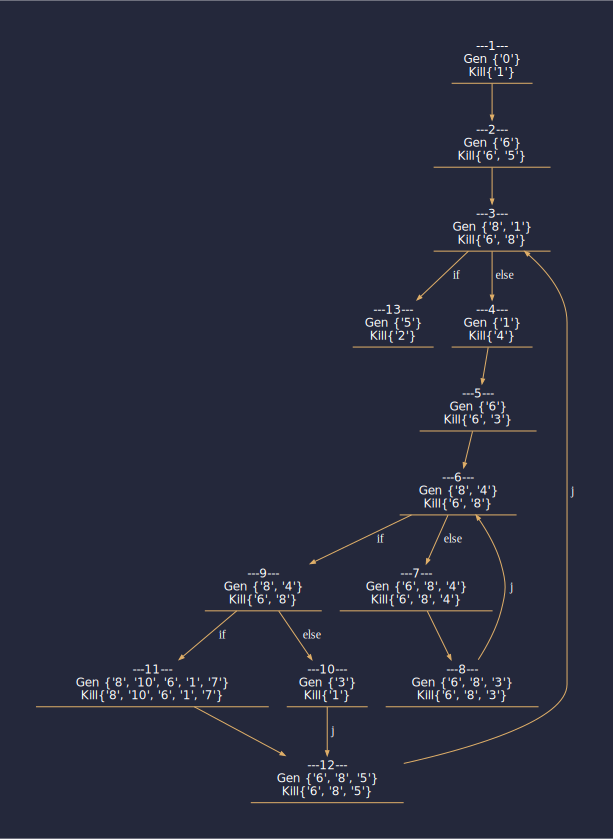

In [42]:
visualize(cfg_collatz,'collatz.cfg',save=False)

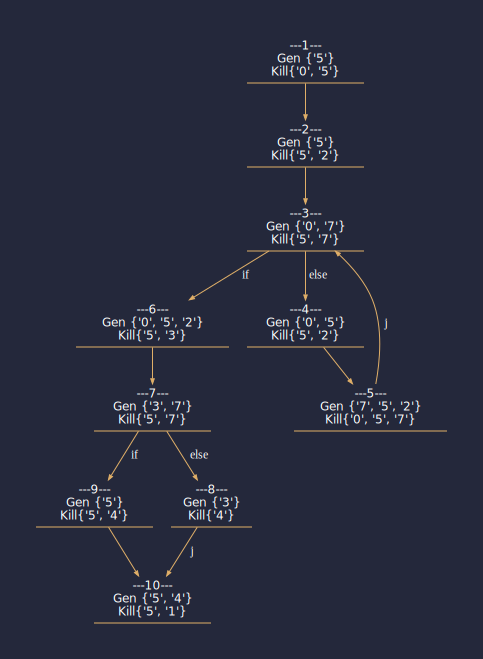

In [43]:
visualize(cfg_arith,'arith.cfg',save=False)

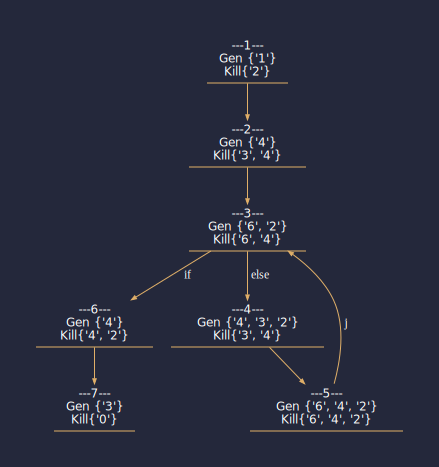

In [44]:
visualize(cfg_factorial,'factorial.cfg',save=False)

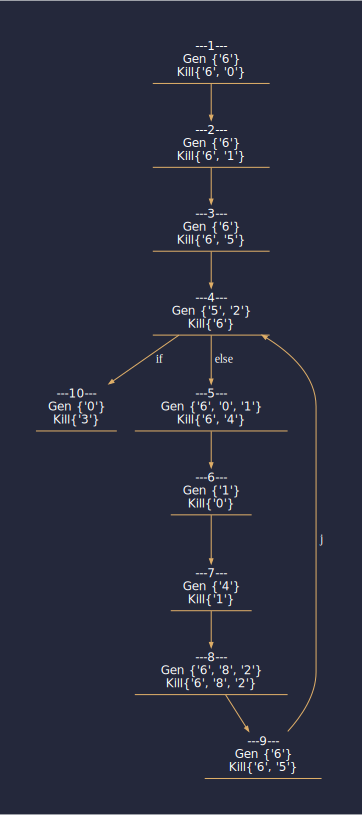

In [45]:
visualize(cfg_fib,'fig.cfg',save=False)

In [ ]:
# def liveness(cfg_):
#     varnames={'0':'a','1':'b','5':'z','2':'n','4':'t','3':'output'}
#     cfg={i:{'gen':set(),'kill':set(),'succ':cfg_[i]['succ']} for i in list(cfg_)}
#     for i in cfg_:
#         for j in ('gen','kill'):
#             for k in cfg_[i][j]:
#                 if k in list(varnames): cfg[i][j].add(varnames[k])
    
#     nBlocks=str(max([int(i) for i in cfg]))    
#     for i in cfg:print('succ',cfg[i]['succ'],'gen',cfg[i]['gen'],'kill',cfg[i]['kill'],'\n')
    
#     def get_in(blocklabel,iteration):
#         _in=cfg[blocklabel]['gen'].union(liveness[iteration]['out'][blocklabel]-cfg[blocklabel]['kill'])
#         return _in
    
#     def get_out(blocklabel,iteration):
#         _out=set()
#         for j in cfg[blocklabel]['succ']: _out=_out.union(liveness[iteration]['in'][j])
#         return _out
    
#     assert(not len(get_out(nBlocks,0))) #out set for the last block should be empty
    
        
#     def iterate_liveness(iteration):
#         liveness[iteration]=copy.deepcopy(liveness[iteration-1])
#         blocklabel=int(nBlocks)
#         while 0<blocklabel:
#             liveness[iteration]['out'][str(blocklabel)]=get_out(str(blocklabel),iteration)
#             liveness[iteration]['in'][str(blocklabel)]=get_in(str(blocklabel),iteration)
#             blocklabel-=1
    
#     liveness={0:{'in':{i:set() for i in list(cfg)},'out':{i:set() for i in list(cfg)}}}
            
#     iteration=1    
#     iterate_liveness(iteration)
#     while liveness[iteration]!=liveness[iteration-1]:
#         iteration+=1
#         iterate_liveness(iteration)
        
#     return liveness
            
# liveness_data=liveness(cfg_fib)

# for j in liveness_data:
#     print('\n--------',j,'--------\n')
#     print('in\n')
#     for i in liveness_data[j]['in']:print(i,liveness_data[j]['in'][i])
#     print('\nout')
#     for i in liveness_data[j]['out']:print(i,liveness_data[j]['out'][i])